In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from transformers import BertTokenizer, TFBertModel

In [15]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [16]:
# Read Data
df = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, encoding='latin')

df.columns = ['label', 'id', 'date', 'query', 'user', 'tweet']

# Data reduction
df = df.drop(['id', 'date', 'query', 'user'], axis=1)

In [17]:
labels_dict = {0:'Negative', 2:'Neutral', 4:'Positive'}

def convert_labels(label):
    return labels_dict[label]

df.label = df.label.apply(lambda x: convert_labels(x))
df

label                                              tweet
0        Negative  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1        Negative  is upset that he can't update his Facebook by ...
2        Negative  @Kenichan I dived many times for the ball. Man...
3        Negative    my whole body feels itchy and like its on fire 
4        Negative  @nationwideclass no, it's not behaving at all....
...           ...                                                ...
1599995  Positive  Just woke up. Having no school is the best fee...
1599996  Positive  TheWDB.com - Very cool to hear old Walt interv...
1599997  Positive  Are you ready for your MoJo Makeover? Ask me f...
1599998  Positive  Happy 38th Birthday to my boo of alll time!!! ...
1599999  Positive  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]

Text(0.5, 1.0, 'Data Distribution')

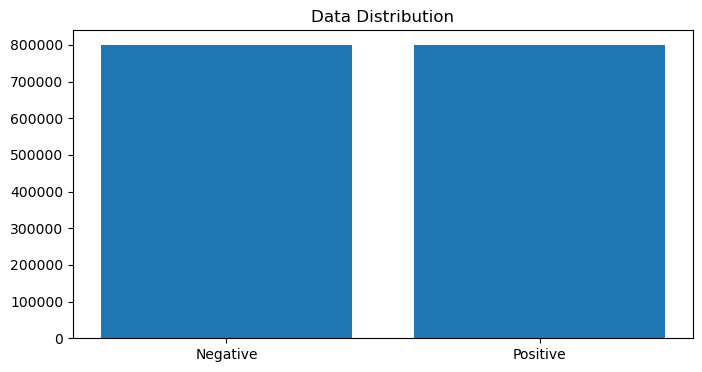

In [18]:
instances = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(instances.index, instances.values)
plt.title("Data Distribution")

In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

punctuations_and_dummies = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"



'''
def preprocess(df, will_be_stemmed=False):
    for index, row in df.iterrows():
        tweet = row.tweet
        tweet = re.sub(punctuations_and_dummies, ' ', str(tweet).lower()).strip()
        tokens = []
        for token in tweet.split():
            if token not in stop_words:
                if will_be_stemmed:
                    tokens.append(stemmer.stem(token))
                else:
                    tokens.append(token)
        df.tweet = " ".join(tokens)


preprocess(df.tweet)
'''


def preprocess(tweet, will_be_stemmed=False):
        tweet = re.sub(punctuations_and_dummies, ' ', str(tweet).lower()).strip()
        tokens = []
        for token in tweet.split():
            if token not in stop_words:
                if will_be_stemmed:
                    tokens.append(stemmer.stem(token))
                else:
                    tokens.append(token)
        return " ".join(tokens)

df.tweet = df.tweet.apply(lambda tw: preprocess(tw))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\faysa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
df.tweet

0               awww bummer shoulda got david carr third day
1          upset update facebook texting might cry result...
2          dived many times ball managed save 50 rest go ...
3                           whole body feels itchy like fire
4                                           behaving mad see
                                 ...                        
1599995                        woke school best feeling ever
1599996             thewdb com cool hear old walt interviews
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: tweet, Length: 1592328, dtype: object

In [20]:
# Remove 0 length tweets
df = df[df.iloc[:,1].astype(str).str.len()!=0]

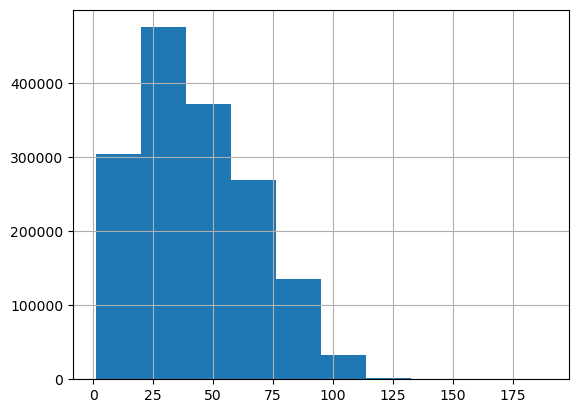

count    1.592328e+06
mean     4.279740e+01
std      2.415896e+01
min      1.000000e+00
25%      2.300000e+01
50%      3.900000e+01
75%      6.000000e+01
max      1.890000e+02
dtype: float64

In [21]:
tweets_len = [len(x) for x in df['tweet']]
pd.Series(tweets_len).hist()
plt.show()
pd.Series(tweets_len).describe()

In [22]:
all_str = ""
for i in df.tweet:
    all_str += i

In [23]:
from collections import Counter

letter_list = list(all_str)
my_counter = Counter(letter_list)

letter_df = pd.DataFrame.from_dict(my_counter, orient='index').reset_index()
letter_df = letter_df.rename(columns={'index':'letter', 0:'frequency'})
letter_df = letter_df.loc[letter_df['letter'].isin(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'])]
letter_df['all_tweets_relative_freq']=letter_df['frequency']/letter_df['frequency'].sum()
letter_df = letter_df.sort_values('letter')

english = pd.read_csv('letter_frequency_en_US.csv')
english['expected_relative_frequency'] = english['count']/english['count'].sum()
english = english.drop(['count'], axis=1)

letter_df = pd.merge(letter_df, english, on='letter')
letter_df['expected'] = np.round(letter_df['expected_relative_frequency']*letter_df['frequency'].sum(),0)
letter_df = letter_df.reset_index().drop(['index'], axis=1)
letter_df

letter  frequency  all_tweets_relative_freq  expected_relative_frequency  \
0       a    4547601                  0.078816                     0.081671   
1       b     975326                  0.016904                     0.014920   
2       c    1705409                  0.029557                     0.027820   
3       d    2289515                  0.039680                     0.042530   
4       e    6471295                  0.112156                     0.127021   
5       f     878849                  0.015232                     0.022280   
6       g    2231747                  0.038679                     0.020150   
7       h    2234047                  0.038719                     0.060941   
8       i    3779579                  0.065505                     0.069661   
9       j     143817                  0.002493                     0.001530   
10      k    1197291                  0.020751                     0.007720   
11      l    3095498                  0.053649                     0.040250   
12      m    1754377                  0.030406                     0.024060   
13      n    3861185                  0.066919                     0.067491   
14      o    4534414                  0.078587                     0.075071   
15      p    1351301                  0.023420                     0.019290   
16      q     115059                  0.001994                     0.000950   
17      r    3179237                  0.055100                     0.059871   
18      s    3595565                  0.062316                     0.063271   
19      t    4153946                  0.071993                     0.090561   
20      u    1676743                  0.029060                     0.027580   
21      v     566733                  0.009822                     0.009780   
22      w    1422401                  0.024652                     0.023600   
23      x     203131                  0.003521                     0.001500   
24      y    1620980                  0.028094                     0.019740   
25      z     114027                  0.001976                     0.000740   

     expected  
0   4712330.0  
1    860879.0  
2   1605204.0  
3   2453966.0  
4   7329010.0  
5   1285548.0  
6   1162648.0  
7   3516217.0  
8   4019358.0  
9     88280.0  
10   445441.0  
11  2322411.0  
12  1388254.0  
13  3894149.0  
14  4331513.0  
15  1113026.0  
16    54815.0  
17  3454478.0  
18  3650657.0  
19  5225280.0  
20  1591356.0  
21   564303.0  
22  1361712.0  
23    86549.0  
24  1138991.0  
25    42698.0

<Axes: ylabel='letter'>

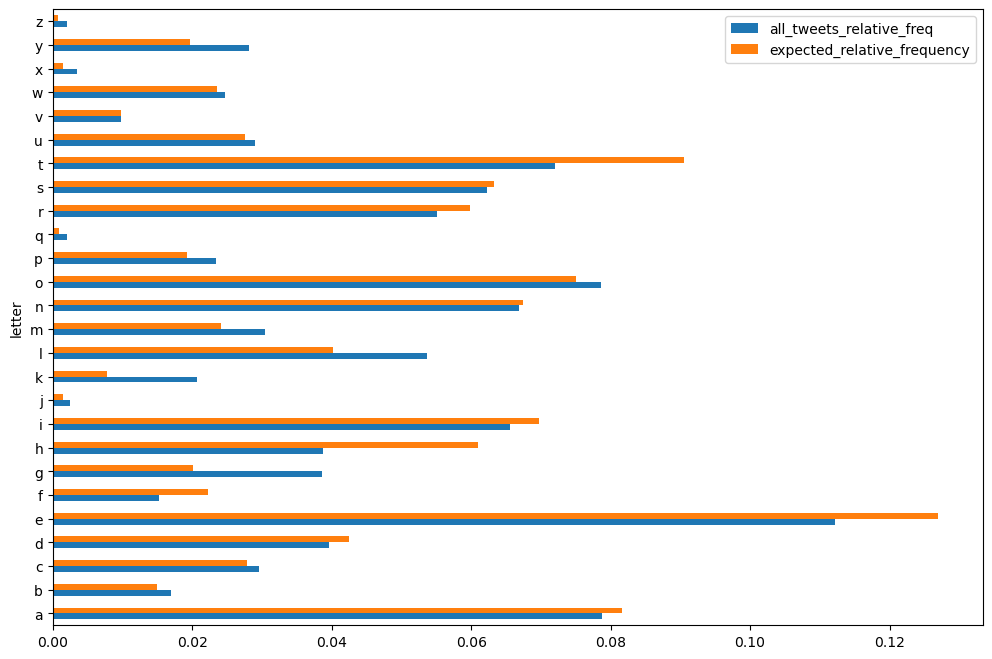

In [24]:
letter_df.plot(x="letter", y=["all_tweets_relative_freq", "expected_relative_frequency"], kind="barh", figsize=(12,8))

In [25]:
from scipy.stats import chi2_contingency
# Chi-square test of independence.
c, p, dof, expected = chi2_contingency(letter_df[['frequency', 'expected']])
p

0.0

In [26]:
letter_df[['frequency', 'expected']].corr()

frequency  expected
frequency   1.000000  0.966795
expected    0.966795  1.000000

In [27]:
df1 = df.copy()

df1['number_of_characters'] = [len(tw) for tw in df1.tweet]
df1

label                                              tweet  \
0        Negative       awww bummer shoulda got david carr third day   
1        Negative  upset update facebook texting might cry result...   
2        Negative  dived many times ball managed save 50 rest go ...   
3        Negative                   whole body feels itchy like fire   
4        Negative                                   behaving mad see   
...           ...                                                ...   
1599995  Positive                      woke school best feeling ever   
1599996  Positive           thewdb com cool hear old walt interviews   
1599997  Positive                    ready mojo makeover ask details   
1599998  Positive  happy 38th birthday boo alll time tupac amaru ...   
1599999  Positive  happy charitytuesday thenspcc sparkscharity sp...   

         number_of_characters  
0                          44  
1                          69  
2                          52  
3                          32  
4                          16  
...                       ...  
1599995                    29  
1599996                    40  
1599997                    31  
1599998                    52  
1599999                    57  

[1592328 rows x 3 columns]

In [28]:
df1.number_of_characters.max()

189

In [29]:
df1.number_of_characters.min()

1

In [30]:
df1.number_of_characters.mean()

42.7974010379771

In [31]:
df1.number_of_characters.std()

24.15896165070398

In [32]:
df1['number_of_words'] = [len(tw.split()) for tw in df1.tweet]
df1

label                                              tweet  \
0        Negative       awww bummer shoulda got david carr third day   
1        Negative  upset update facebook texting might cry result...   
2        Negative  dived many times ball managed save 50 rest go ...   
3        Negative                   whole body feels itchy like fire   
4        Negative                                   behaving mad see   
...           ...                                                ...   
1599995  Positive                      woke school best feeling ever   
1599996  Positive           thewdb com cool hear old walt interviews   
1599997  Positive                    ready mojo makeover ask details   
1599998  Positive  happy 38th birthday boo alll time tupac amaru ...   
1599999  Positive  happy charitytuesday thenspcc sparkscharity sp...   

         number_of_characters  number_of_words  
0                          44                8  
1                          69               11  
2                          52               10  
3                          32                6  
4                          16                3  
...                       ...              ...  
1599995                    29                5  
1599996                    40                7  
1599997                    31                5  
1599998                    52                9  
1599999                    57                5  

[1592328 rows x 4 columns]

In [33]:
df1.number_of_words.max()

50

In [34]:
df1.number_of_words.min()

1

In [35]:
df1.number_of_words.mean()

7.244474128445898

In [36]:
df1.number_of_words.std()

4.030421805717334

<BarContainer object of 20 artists>

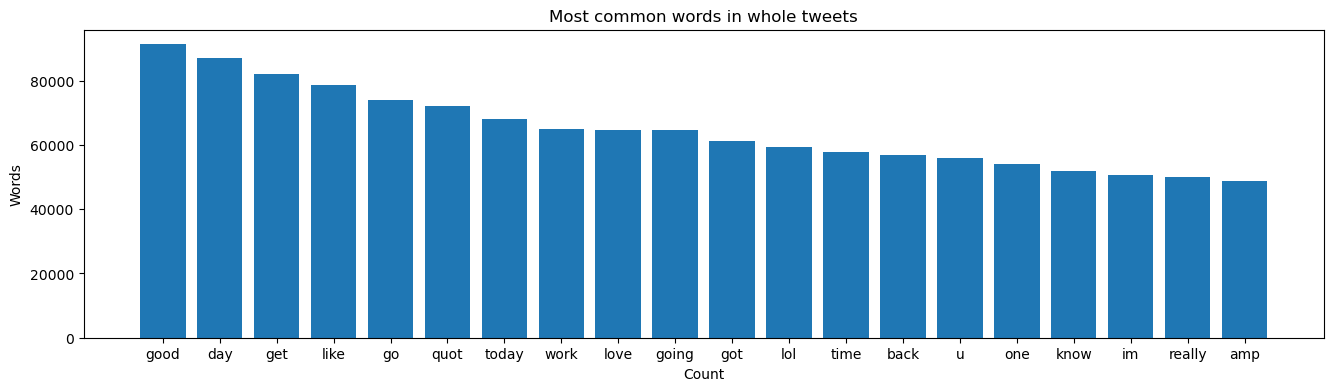

In [37]:
import collections
from wordcloud import WordCloud
from nltk import word_tokenize, sent_tokenize
from nltk.util import ngrams

all_tweets = ' '.join(df['tweet'].str.lower())

f_words = [word for word in all_tweets.split()]
counted_words = collections.Counter(f_words)

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)

plt.figure(figsize = (16, 4))
plt.title('Most common words in whole tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.bar(words, counts)

<BarContainer object of 20 artists>

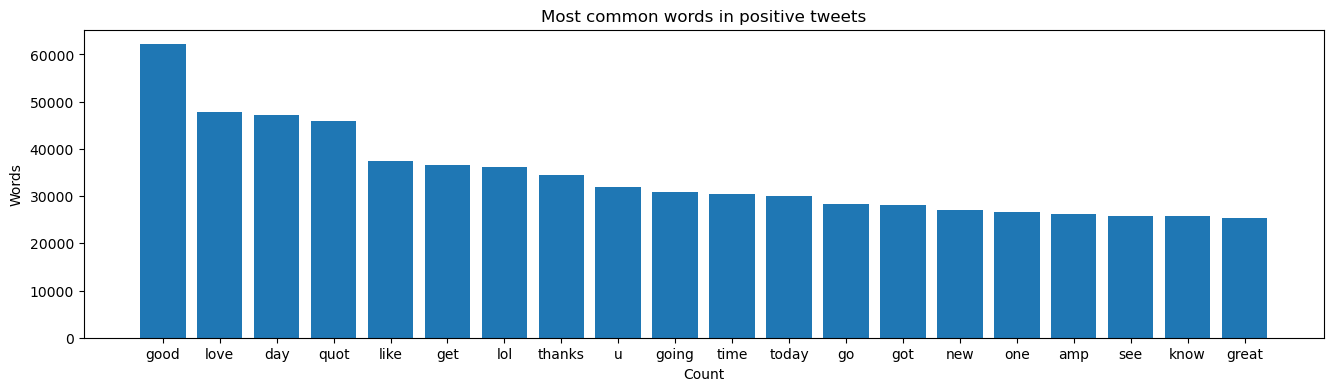

In [38]:
all_tweets = ' '.join(df[df.label == 'Positive'].tweet.str.lower())

f_words = [word for word in all_tweets.split()]
counted_words = collections.Counter(f_words)

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)

plt.figure(figsize = (16, 4))
plt.title('Most common words in positive tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.bar(words, counts)

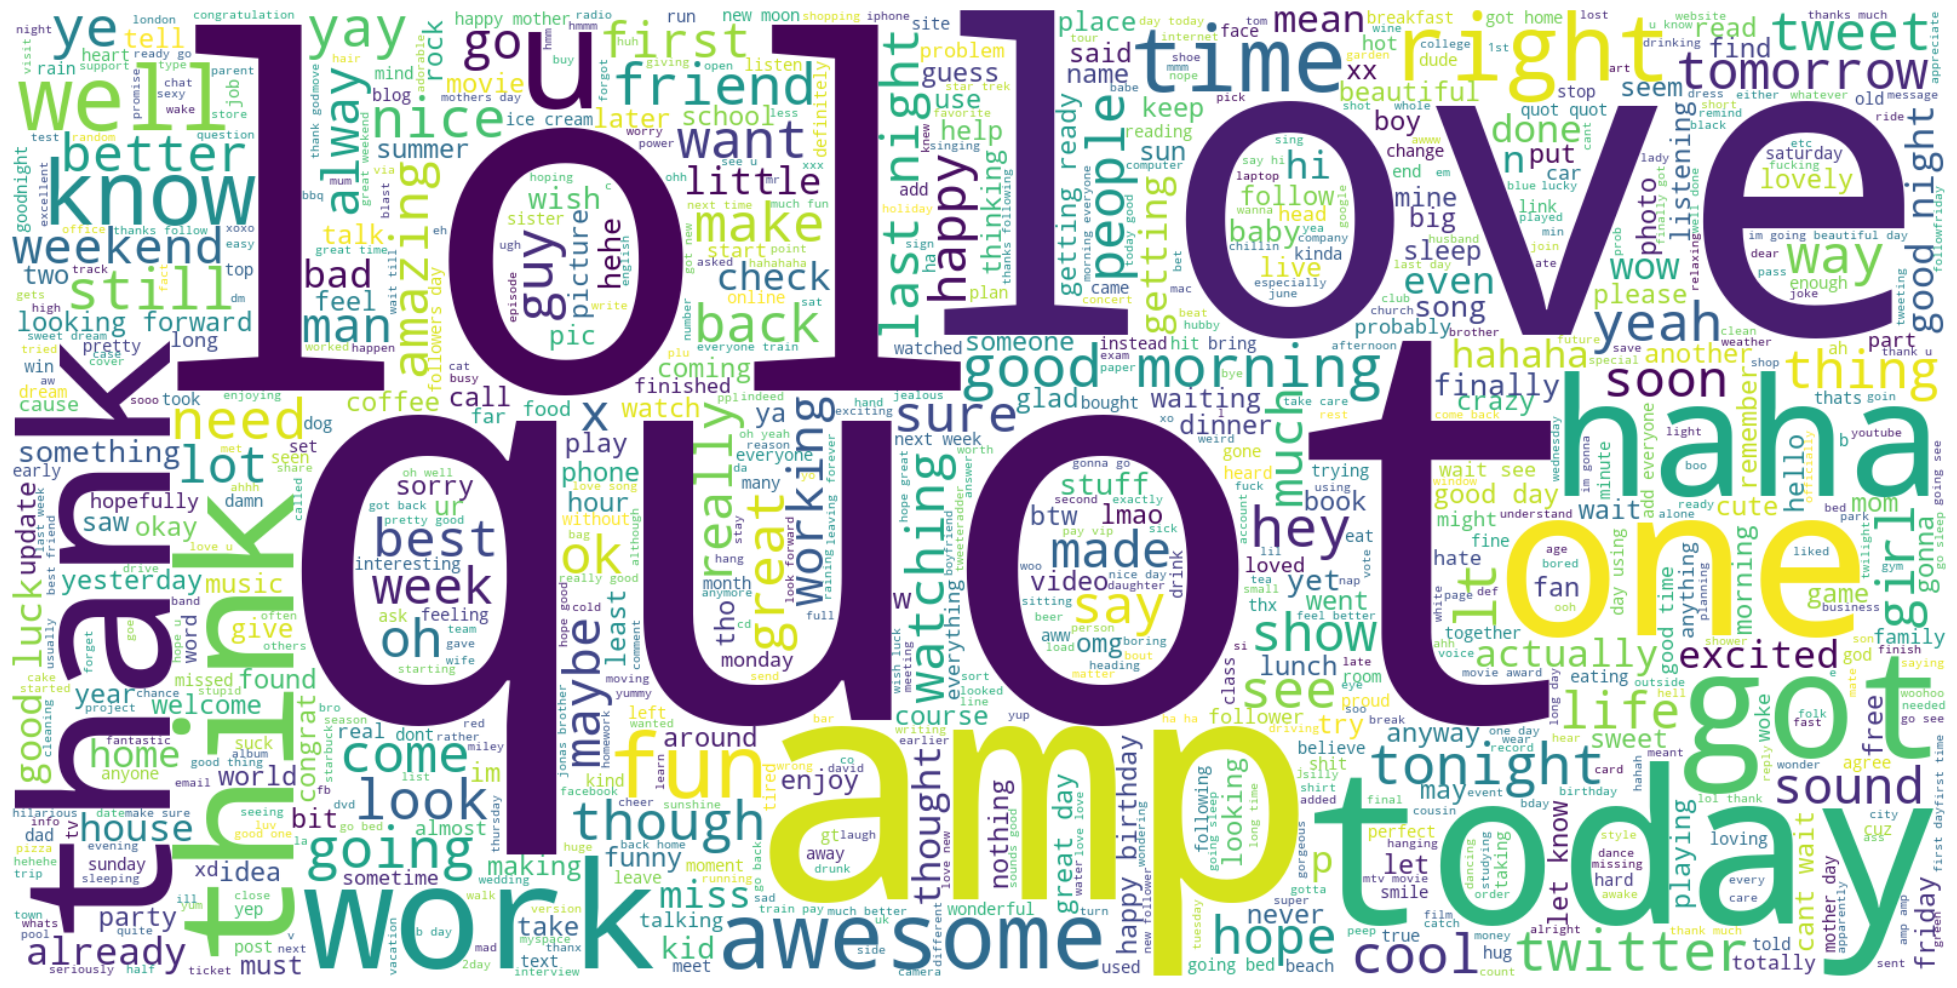

In [39]:
plt.figure(figsize = (25, 25))
plt.axis('off')
wordcloud_fig = WordCloud(max_words = 2000 , width = 1600 , height = 800, background_color ='white', min_font_size = 10).generate(" ".join(df[df.label == 'Positive'].tweet))
plt.imshow(wordcloud_fig, interpolation = 'bilinear')

<BarContainer object of 20 artists>

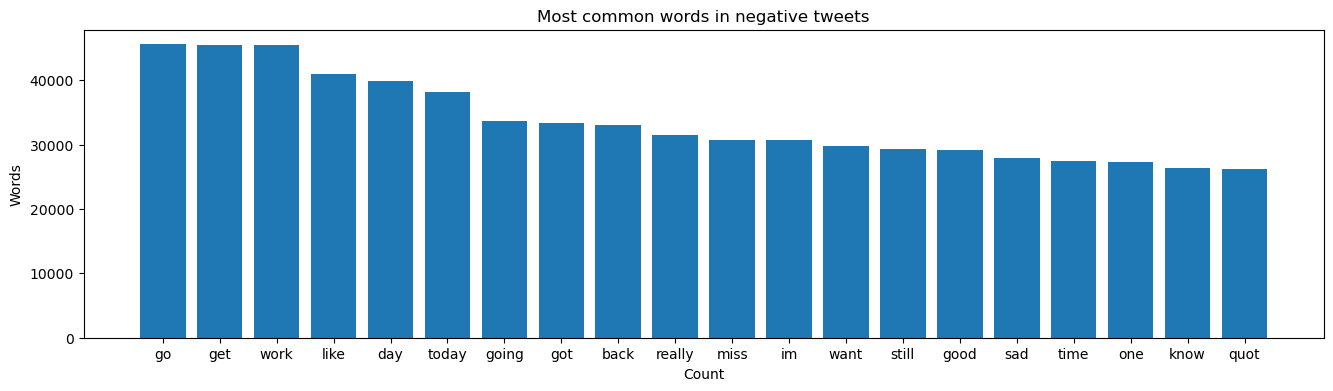

In [40]:
all_tweets = ' '.join(df[df.label == 'Negative'].tweet.str.lower())

f_words = [word for word in all_tweets.split()]
counted_words = collections.Counter(f_words)

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)

plt.figure(figsize = (16, 4))
plt.title('Most common words in negative tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.bar(words, counts)

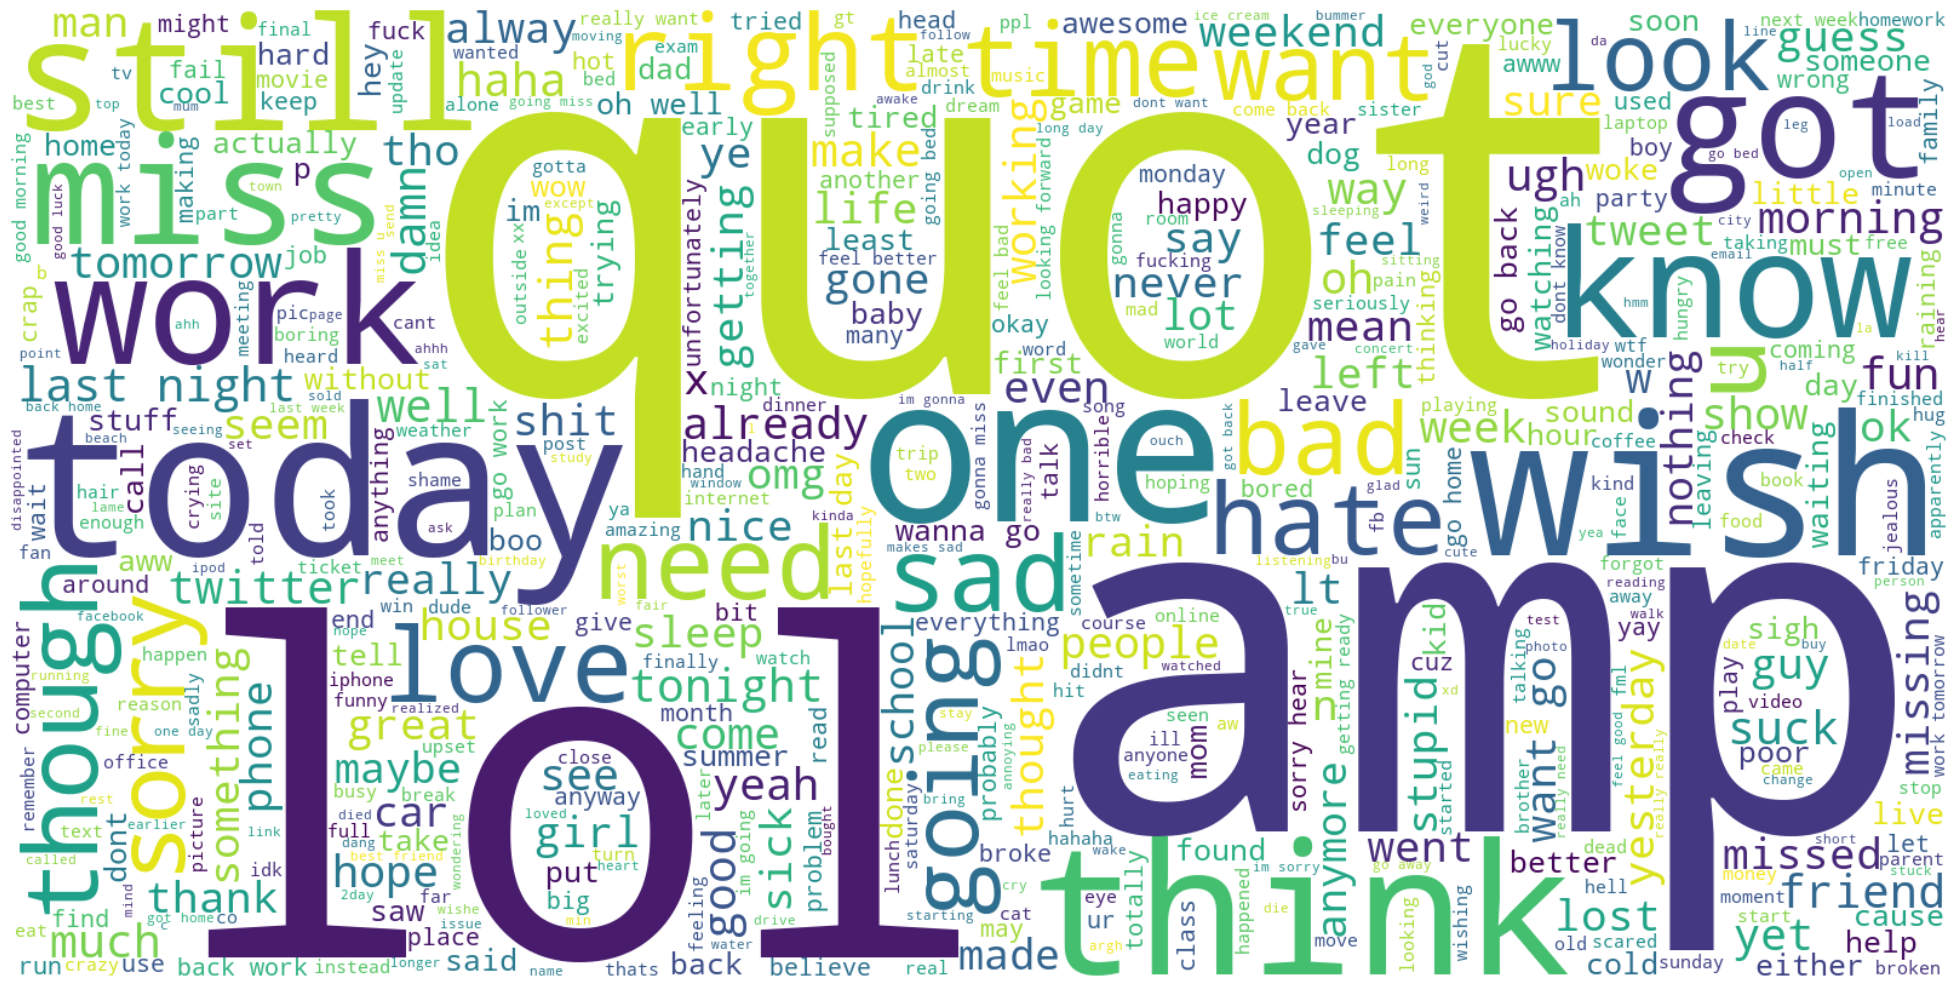

In [41]:
from wordcloud import WordCloud

plt.figure(figsize = (25, 25))
plt.axis('off')
wordcloud_fig = WordCloud(max_words = 2000 , width = 1600 , height = 800, background_color ='white', min_font_size = 10).generate(" ".join(df[df.label == 'Negative'].tweet))
plt.imshow(wordcloud_fig, interpolation = 'bilinear')

In [42]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=7)
print('Training Data', len(train_data), 'Test Data', len(test_data))

train_data.head(10)

Training Data 1273862 Test Data 318466


label                                              tweet
927561   Positive                                              thank
810082   Positive         shakin money tree headed back car business
1153331  Positive                        tasmania okay chat ya later
988182   Positive        yeah 100 tab storm towelled raiders awesome
543405   Negative  happy mari asleep gotta start laundry b4 wakes...
22855    Negative           wanting go city raining gotta homework 2
483675   Negative                               sitting home bored x
667231   Negative                                     miss amy cards
1370823  Positive                       dinner hubby two us 10 coupo
94439    Negative                           know prob running around

In [43]:
test_data.head(10)

label                                              tweet
1414233  Positive                                    nice job thanks
181653   Negative                      way wanna shower n get pretty
788422   Negative           woke early think anyone completely bored
76646    Negative           lucky u scheduled today happy camper lol
972366   Positive  way cute curt hope school raised tons money lo...
797869   Negative                      stupid braces making lips dry
1129919  Positive                                          good miss
1036078  Positive         past days sucked hopefully weekend happier
550532   Negative  marcus doubt megan fox good 2 years might get ...
1365388  Positive  going school contempt fash exams going conquer...

In [ ]:
# DecisionTreeClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.ensemble import RandomForestClassifier


from sklearn.svm import SVC


# Splitting the data into train and test sets (70% train, 30% test)
train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data in the training set
X_train = tfidf_vectorizer.fit_transform(train_data['tweet'])  # Assuming 'tweet' is the text column

# # Initialize the classifier and fit it to the TF-IDF transformed data

clf = DecisionTreeClassifier()

# Initialize the Random Forest classifier
# clf = RandomForestClassifier()


# Initialize the SVM classifier
# clf = SVC()


clf.fit(X_train, train_data['label'])

# Transform the test data using the same vectorizer
X_test = tfidf_vectorizer.transform(test_data['tweet'])

# Make predictions on the test data

predictions = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(test_data['label'], predictions)

# Calculate recall, precision, and F1-score for the positive class
recall_positive = recall_score(test_data['label'], predictions, pos_label='Positive')
precision_positive = precision_score(test_data['label'], predictions, pos_label='Positive')
f1_positive = f1_score(test_data['label'], predictions, pos_label='Positive')

# Calculate recall, precision, and F1-score for the negative class
recall_negative = recall_score(test_data['label'], predictions, pos_label='Negative')
precision_negative = precision_score(test_data['label'], predictions, pos_label='Negative')
f1_negative = f1_score(test_data['label'], predictions, pos_label='Negative')



# Sensitivity is the same as recall in binary classification
sensitivity = recall_positive

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Recall (Positive class):", recall_positive)
print("Precision (Positive class):", precision_positive)
print("F1-Score (Positive class):", f1_positive)
print("Recall (Negative class):", recall_negative)
print("Precision (Negative class):", precision_negative)
print("F1-Score (Negative class):", f1_negative)
print("Sensitivity:", sensitivity)



In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_data['label'], predictions, labels=["Positive", "Negative"])

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
# RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.ensemble import RandomForestClassifier


from sklearn.svm import SVC


# Splitting the data into train and test sets (70% train, 30% test)
train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data in the training set
X_train = tfidf_vectorizer.fit_transform(train_data['tweet'])  # Assuming 'tweet' is the text column

# # Initialize the classifier and fit it to the TF-IDF transformed data

# clf = DecisionTreeClassifier()

# Initialize the Random Forest classifier
clf = RandomForestClassifier()


# Initialize the SVM classifier
# clf = SVC()


clf.fit(X_train, train_data['label'])

# Transform the test data using the same vectorizer
X_test = tfidf_vectorizer.transform(test_data['tweet'])

# Make predictions on the test data
predictions = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(test_data['label'], predictions)

# Calculate recall, precision, and F1-score for the positive class
recall_positive = recall_score(test_data['label'], predictions, pos_label='Positive')
precision_positive = precision_score(test_data['label'], predictions, pos_label='Positive')
f1_positive = f1_score(test_data['label'], predictions, pos_label='Positive')

# Calculate recall, precision, and F1-score for the negative class
recall_negative = recall_score(test_data['label'], predictions, pos_label='Negative')
precision_negative = precision_score(test_data['label'], predictions, pos_label='Negative')
f1_negative = f1_score(test_data['label'], predictions, pos_label='Negative')



# Sensitivity is the same as recall in binary classification
sensitivity = recall_positive

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Recall (Positive class):", recall_positive)
print("Precision (Positive class):", precision_positive)
print("F1-Score (Positive class):", f1_positive)
print("Recall (Negative class):", recall_negative)
print("Precision (Negative class):", precision_negative)
print("F1-Score (Negative class):", f1_negative)
print("Sensitivity:", sensitivity)



In [ ]:
# MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Multinomial Naive Bayes classifier
clf = MultinomialNB()

# Fit the classifier to the TF-IDF transformed data
clf.fit(X_train, train_data['label'])

# Make predictions on the test data
predictions = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(test_data['label'], predictions)

# Calculate recall, precision, and F1-score for the positive class
recall_positive = recall_score(test_data['label'], predictions, pos_label='Positive')
precision_positive = precision_score(test_data['label'], predictions, pos_label='Positive')
f1_positive = f1_score(test_data['label'], predictions, pos_label='Positive')

# Calculate recall, precision, and F1-score for the negative class
recall_negative = recall_score(test_data['label'], predictions, pos_label='Negative')
precision_negative = precision_score(test_data['label'], predictions, pos_label='Negative')
f1_negative = f1_score(test_data['label'], predictions, pos_label='Negative')

# Sensitivity is the same as recall in binary classification
sensitivity = recall_positive

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Recall (Positive class):", recall_positive)
print("Precision (Positive class):", precision_positive)
print("F1-Score (Positive class):", f1_positive)
print("Recall (Negative class):", recall_negative)
print("Precision (Negative class):", precision_negative)
print("F1-Score (Negative class):", f1_negative)
print("Sensitivity:", sensitivity)


In [ ]:
# SVC


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.ensemble import RandomForestClassifier


from sklearn.svm import SVC


# Splitting the data into train and test sets (70% train, 30% test)
train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data in the training set
X_train = tfidf_vectorizer.fit_transform(train_data['tweet'])  # Assuming 'tweet' is the text column

# Initialize the SVM classifier
clf = SVC()


clf.fit(X_train, train_data['label'])

# Transform the test data using the same vectorizer
X_test = tfidf_vectorizer.transform(test_data['tweet'])

# Make predictions on the test data
predictions = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(test_data['label'], predictions)

# Calculate recall, precision, and F1-score for the positive class
recall_positive = recall_score(test_data['label'], predictions, pos_label='Positive')
precision_positive = precision_score(test_data['label'], predictions, pos_label='Positive')
f1_positive = f1_score(test_data['label'], predictions, pos_label='Positive')

# Calculate recall, precision, and F1-score for the negative class
recall_negative = recall_score(test_data['label'], predictions, pos_label='Negative')
precision_negative = precision_score(test_data['label'], predictions, pos_label='Negative')
f1_negative = f1_score(test_data['label'], predictions, pos_label='Negative')



# Sensitivity is the same as recall in binary classification
sensitivity = recall_positive

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Recall (Positive class):", recall_positive)
print("Precision (Positive class):", precision_positive)
print("F1-Score (Positive class):", f1_positive)
print("Recall (Negative class):", recall_negative)
print("Precision (Negative class):", precision_negative)
print("F1-Score (Negative class):", f1_negative)
print("Sensitivity:", sensitivity)

In [ ]:
# Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Splitting the data into train and test sets (70% train, 30% test)
train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data in the training set
X_train = tfidf_vectorizer.fit_transform(train_data['tweet'])

# Model 1: Logistic Regression
print("Training Logistic Regression...")
logistic_model = LogisticRegression()
logistic_model.fit(X_train, train_data['label'])

# Transform the test data using the same vectorizer
X_test = tfidf_vectorizer.transform(test_data['tweet'])
# Make predictions on the test data
logistic_predictions = logistic_model.predict(X_test)

# Calculate evaluation metrics for Logistic Regression
logistic_accuracy = accuracy_score(test_data['label'], logistic_predictions)
logistic_recall_positive = recall_score(test_data['label'], logistic_predictions, pos_label='Positive')
logistic_precision_positive = precision_score(test_data['label'], logistic_predictions, pos_label='Positive')
logistic_f1_positive = f1_score(test_data['label'], logistic_predictions, pos_label='Positive')
logistic_recall_negative = recall_score(test_data['label'], logistic_predictions, pos_label='Negative')
logistic_precision_negative = precision_score(test_data['label'], logistic_predictions, pos_label='Negative')
logistic_f1_negative = f1_score(test_data['label'], logistic_predictions, pos_label='Negative')
logistic_sensitivity = logistic_recall_positive

# Print evaluation metrics for Logistic Regression
print("\nLogistic Regression Evaluation Metrics:")
print("Accuracy:", logistic_accuracy)
print("Recall (Positive class):", logistic_recall_positive)
print("Precision (Positive class):", logistic_precision_positive)
print("F1-Score (Positive class):", logistic_f1_positive)
print("Recall (Negative class):", logistic_recall_negative)
print("Precision (Negative class):", logistic_precision_negative)
print("F1-Score (Negative class):", logistic_f1_negative)
print("Sensitivity:", logistic_sensitivity)
print("---------------------------------------------------------")

In [ ]:
MODELS_PATH = 'models'
EMBEDDING_DIMENSION = 300

In [ ]:
# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(test_data['label'], predictions)

# Compute confusion matrix
# cm = confusion_matrix(y_test, clf.predict(X_test))

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['Negative', 'Positive'], yticklabels=['
', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Roc Curve

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc(fpr, tpr):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from transformers import BertTokenizer, TFBertModel

In [ ]:
# CNN Model

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np

# Assuming train_data['tweet'] contains your tweet texts

# Tokenize tweets into words
tokenized_tweets = [word_tokenize(tweet) for tweet in train_data['tweet']]

# Flatten the list of tokenized tweets
all_tokens = [token for tweet_tokens in tokenized_tweets for token in tweet_tokens]

# Count unique tokens
vocab_size = len(set(all_tokens))

# Compute maximum sequence length
max_length = max([len(tweet_tokens) for tweet_tokens in tokenized_tweets])

print("Vocabulary Size:", vocab_size)
print("Maximum Sequence Length:", max_length)


In [ ]:
# Tokenize the text data
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['tweet'])
X_train = tokenizer.texts_to_sequences(train_data['tweet'])
X_test = tokenizer.texts_to_sequences(test_data['tweet'])

# Pad the sequences
max_length = max([len(seq) for seq in X_train + X_test])
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

# Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Define the model architecture
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dense(units=64, activation='relu'),
    Dropout(0.3),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {accuracy}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate other metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("CNN Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
conf_matrix = confusion_matrix(y_test, y_pred)
print("CNN Confusion Matrix:\n", conf_matrix)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [ ]:
# Tokenize the text data
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['tweet'])
X_train = tokenizer.texts_to_sequences(train_data['tweet'])
X_test = tokenizer.texts_to_sequences(test_data['tweet'])

# Pad the sequences
max_length = max([len(seq) for seq in X_train + X_test])
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

# Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1


# Define the model architecture with increased complexity
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.3),
    Dense(units=1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {accuracy}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate other metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("CNN Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
conf_matrix = confusion_matrix(y_test, y_pred)
print("CNN Confusion Matrix:\n", conf_matrix)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [ ]:
# Tokenize the text data
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['tweet'])
X_train = tokenizer.texts_to_sequences(train_data['tweet'])
X_test = tokenizer.texts_to_sequences(test_data['tweet'])

# Pad the sequences
max_length = max([len(seq) for seq in X_train + X_test])
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

# Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1


# Define the model architecture with increased complexity
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.3),
    Dense(units=1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {accuracy}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate other metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("CNN Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
conf_matrix = confusion_matrix(y_test, y_pred)
print("CNN Confusion Matrix:\n", conf_matrix)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

# Train the model with the learning rate scheduler
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {accuracy}")

In [ ]:

# BERT Model

In [ ]:
# Tokenize the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train = [tokenizer.encode(text, add_special_tokens=True, max_length=max_length, pad_to_max_length=True) for text in train_data['tweet']]
X_test = [tokenizer.encode(text, add_special_tokens=True, max_length=max_length, pad_to_max_length=True) for text in test_data['tweet']]

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

# Define the model architecture
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
embeddings = bert_model([input_ids, input_mask])[1]
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(embeddings)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([np.array(X_train), np.array([np.ones_like(X_train[0])]*len(X_train))], y_train, epochs=5, batch_size=64, validation_data=([np.array(X_test), np.array([np.ones_like(X_test[0])]*len(X_test))], y_test))

# Evaluate the model
loss, accuracy = model.evaluate([np.array(X_test), np.array([np.ones_like(X_test[0])]*len(X_test))], y_test)
print(f"BERT Test Accuracy: {accuracy}")

# Generate predictions
y_pred = model.predict([np.array(X_test), np.array([np.ones_like(X_test[0])]*len(X_test))])
y_pred = (y_pred > 0.5).astype(int)

# Calculate other metrics
print("BERT Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
conf_matrix = confusion_matrix(y_test, y_pred)
print("BERT Confusion Matrix:\n", conf_matrix)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERT Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()